In [4]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset

In [5]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

cuda


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
train_transform = v2.Compose([
    v2.RandomResizedCrop(size=(64, 64), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.ColorJitter(brightness=0.2),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 32

# trainset = ImageFolder("/content/data/train/", transform=train_transform)
dataset = ImageFolder("./train/")

num_samples = len(dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)

split = int(0.8 * num_samples)
train_indices = indices[:split]
test_indices = indices[split:]

train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)

class TransformingDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_dataset = TransformingDataset(train_data, train_transform)
test_dataset = TransformingDataset(test_data, test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


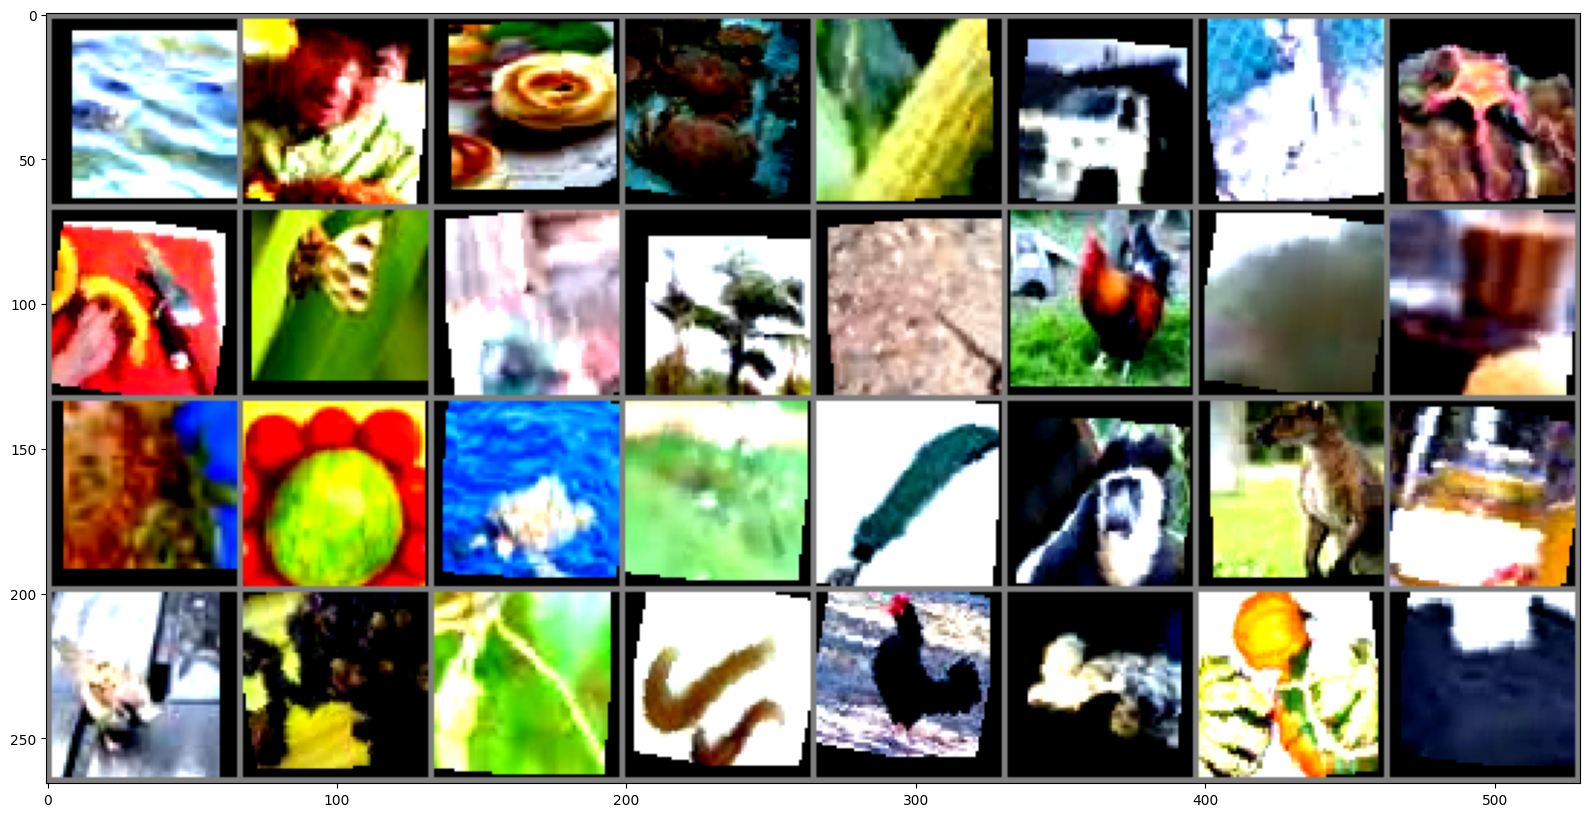

In [7]:
plt.figure(figsize = (20,10))

images, labels = next(iter(train_loader))

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))

In [8]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.LeakyReLU(negative_slope=0.01, inplace=True)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.relu_fc1 = nn.LeakyReLU(negative_slope=0.01, inplace=True)

        self.dropout = nn.Dropout(0.2)

        self.fc2 = nn.Linear(512, 50)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)

        x = self.fc2(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)

print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01, inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01, inplace=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)

In [10]:
losses = []
for epoch in range(50):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('[%d/30] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    losses.append(running_loss / 2000)
    running_loss = 0.0

print('Finished Training')

[1/30] loss: 3.548
[2/30] loss: 3.193
[3/30] loss: 2.985
[4/30] loss: 2.837
[5/30] loss: 2.732
[6/30] loss: 2.646
[7/30] loss: 2.576
[8/30] loss: 2.514
[9/30] loss: 2.461
[10/30] loss: 2.424
[11/30] loss: 2.381
[12/30] loss: 2.354
[13/30] loss: 2.320
[14/30] loss: 2.291
[15/30] loss: 2.258
[16/30] loss: 2.231
[17/30] loss: 2.208
[18/30] loss: 2.186
[19/30] loss: 2.168
[20/30] loss: 2.147
[21/30] loss: 2.135
[22/30] loss: 2.111
[23/30] loss: 2.100
[24/30] loss: 2.076
[25/30] loss: 2.068
[26/30] loss: 2.052
[27/30] loss: 2.042
[28/30] loss: 2.026
[29/30] loss: 2.008
[30/30] loss: 2.006
[31/30] loss: 1.991
[32/30] loss: 1.969
[33/30] loss: 1.974
[34/30] loss: 1.954
[35/30] loss: 1.951
[36/30] loss: 1.957
[37/30] loss: 1.937
[38/30] loss: 1.918
[39/30] loss: 1.916
[40/30] loss: 1.907
[41/30] loss: 1.894
[42/30] loss: 1.893
[43/30] loss: 1.887
[44/30] loss: 1.878
[45/30] loss: 1.871
[46/30] loss: 1.866
[47/30] loss: 1.859
[48/30] loss: 1.856
[49/30] loss: 1.841
[50/30] loss: 1.836
Finished 

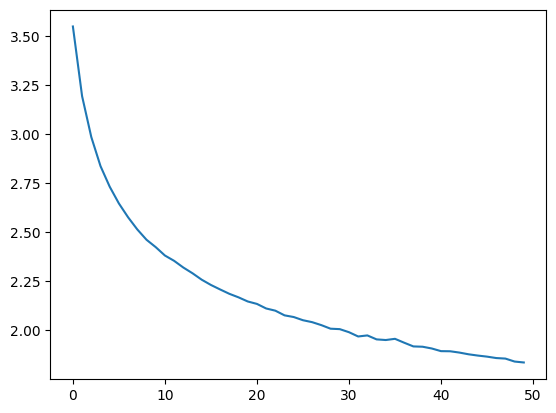

In [11]:
plt.plot(losses)
plt.show()

In [13]:
net.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        output = torch.argmax(outputs, dim=1)

        y_pred_list.extend(output.cpu().numpy().tolist())
        y_true_list.extend(labels.cpu().numpy().tolist())

correct_predictions = sum([1 for i in range(len(y_pred_list)) if y_pred_list[i] == y_true_list[i]])
accuracy = (correct_predictions / len(y_pred_list)) * 100

print(f"Classification accuracy: {accuracy:.2f}%")

Classification accuracy: 62.68%


In [16]:
from PIL import Image
import os

test_dir =  './test_all'

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_folder))  # zachowuje oryginalne nazwy

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name

test_dataset = TestDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [17]:
import csv

net.eval()

results = []

with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = net(images)
        _, preds = torch.max(outputs, 1)

        for filename, pred in zip(filenames, preds):
            results.append((filename, pred.item()))

with open('pred.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(results)